# FashionMnist图像分类实验

## 实验介绍

本实验主要介绍使用MindSpore开发前馈神经网络，并使用Fashion-MNIST数据集训练和测试模型。

## 实验目的

- 掌握如何使用MindSpore进行简单前馈神经网络的开发。
- 了解如何使用MindSpore进行简单图片分类任务的训练。
- 了解如何使用MindSpore进行简单图片分类任务的测试和预测。

## 预备知识

- 熟练使用Python。
- 具备一定的深度学习理论知识，如感知机、前馈神经网络、损失函数、优化器，训练策略等。
- 了解华为云的基本使用方法，包括[OBS（对象存储）](https://www.huaweicloud.com/product/obs.html)、[ModelArts（AI开发平台）](https://www.huaweicloud.com/product/modelarts.html)、[训练作业](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0046.html)等功能。华为云官网：https://www.huaweicloud.com
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn/

## 实验环境

- MindSpore 1.1.1（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 华为云ModelArts：ModelArts是华为云提供的面向开发者的一站式AI开发平台，集成了昇腾AI处理器资源池，用户可以在该平台下体验MindSpore。

### 数据集准备

Fashion-MNIST是一个替代MNIST手写数字集的图像数据集。 它是由Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自10种类别的共7万个不同商品的正面图片。Fashion-MNIST的大小、格式和训练集/测试集划分与原始的MNIST完全一致。60000/10000的训练测试数据划分，28x28x1的灰度图片。

这里介绍一下经典的MNIST（手写字母）数据集。经典的MNIST数据集包含了大量的手写数字。十几年来，来自机器学习、机器视觉、人工智能、深度学习领域的研究员们把这个数据集作为衡量算法的基准之一。实际上，MNIST数据集已经成为算法作者的必测的数据集之一，但是MNIST数据集太简单了。很多深度学习算法在测试集上的准确率已经达到99.6%。

从[Fashion-MNIST GitHub仓库](https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion)下载如下4个文件到本地并解压：

```
train-images-idx3-ubyte     training set images（47,042,560 bytes）   
train-labels-idx1-ubyte     training set labels（61,440 bytes）  
t10k-images-idx3-ubyte      test set images (7,843,840 bytes)  
t10k-labels-idx1-ubyte      test set labels (12,288 bytes) 
```

## 实验步骤

### 代码梳理

#### 导入MindSpore模块和辅助模块

用到的框架主要包括：

- mindspore，用于神经网络的搭建 
- numpy，用于处理一些数据 
- matplotlib，用于画图、图像展示
- struct，用于处理二进制文件

In [1]:
import os
import struct
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import Tensor

context.set_context(mode=context.GRAPH_MODE, device_target='GPU')


#### 变量定义

In [2]:
cfg = edict({
    'train_size': 60000,  # 训练集大小
    'test_size': 10000,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 60,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 10,  # 训练次数
    #此处应该改为自己数据集存储的路径，分别用train和test两个文件夹存储训练数据集和测试数据集
    'data_dir_train': os.path.join('./data'),
    'data_dir_test': os.path.join('./data'),
    'save_checkpoint_steps': 1,  # 多少步保存一次模型
    'keep_checkpoint_max': 3,  # 最多保存多少个模型
    'output_directory': './model_fashion',  # 保存模型路径
    'output_prefix': "checkpoint_fashion_forward"  # 保存模型文件名字
})

#### 读取并处理数据

读取数据

In [3]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y

数据预处理和处理结果图片展示

In [4]:
print(os.getcwd())

/home/ma-user/work


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


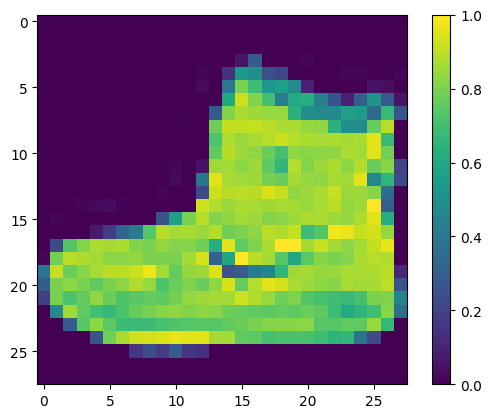

In [5]:
train_x, train_y, test_x, test_y = get_data()
#第一维度是batchsize的数据,第二维度是图像的channel数，第三，第四维度是高和宽
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
#归一化至0和1之间
train_x = train_x / 255.0
test_x = test_x / 255.0
#修改数据格式
train_x = train_x.astype('Float32')
test_x = test_x.astype('Float32')
train_y = train_y.astype('int32')
test_y = test_y.astype('int32')
print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0])  # 一共10类，用0-9的数字表达类别。

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

使用MindSpore  GeneratorDataset接口将numpy.ndarray类型的数据转换为Dataset

In [6]:
# 转换数据类型为Dataset
XY_train = list(zip(train_x, train_y))
#转换数据和标签为dataset类型，并制定数据为x，标签为y
ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
ds_train = ds_train.shuffle(buffer_size=cfg.train_size).batch(cfg.batch_size, drop_remainder=True)
XY_test = list(zip(test_x, test_y))
ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
ds_test = ds_test.shuffle(buffer_size=cfg.test_size).batch(cfg.batch_size, drop_remainder=True)

#### 定义神经网络

可以使用最简单的全连接网络，也可以使用CNN网络


In [7]:
from mindspore import nn, Model, context
from mindspore.common.initializer import Normal
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig

# 定义神经网络
class Forward_fashion(nn.Cell):
    def __init__(self, num_classes=10, num_channel=1):  # 一共分十类，图片通道数是1
        super(Forward_fashion, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='same')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_classes, weight_init=Normal(0.02))

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 确保配置参数存在
class Config:
    def __init__(self):
        self.num_classes = 10
        self.lr = 0.001
        self.epoch_size = 30
        self.batch_size = 32
        self.train_size = 60000
        self.save_checkpoint_steps = 100
        self.keep_checkpoint_max = 5
        self.output_prefix = "fashion_mnist"
        self.output_directory = "./checkpoints"

cfg = Config()

#### 训练

使用Fashion-MNIST数据集对上述定义的前馈神经网络模型进行训练。训练策略如下表所示，可以调整训练策略并查看训练效果。

batch size|number of epochs	| learning rate	|input shape|optimizer
:--:|:--:|:--:|:--:|:--:
60|30|0.001|(1，28，28)|Adam

In [8]:
network = Forward_fashion(cfg.num_classes)

# 定义模型的损失函数和优化器
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
net_opt = nn.Adam(network.trainable_params(), learning_rate=cfg.lr)

# 构建模型
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})

# 设定回调
loss_cb = LossMonitor(per_print_times=int(cfg.train_size / cfg.batch_size))
config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps,
                             keep_checkpoint_max=cfg.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix=cfg.output_prefix, directory=cfg.output_directory, config=config_ck)

# 训练模型
print("============== Starting Training ==============")
model.train(cfg.epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb], dataset_sink_mode=False)

============== Starting Training ==============
epoch: 2 step: 875, loss is 0.35765445
epoch: 4 step: 750, loss is 0.44777822
epoch: 6 step: 625, loss is 0.39919627
epoch: 8 step: 500, loss is 0.259171
epoch: 10 step: 375, loss is 0.28298184
epoch: 12 step: 250, loss is 0.37424833
epoch: 14 step: 125, loss is 0.16585918
epoch: 15 step: 1000, loss is 0.40086138
epoch: 17 step: 875, loss is 0.54310215
epoch: 19 step: 750, loss is 0.19051328
epoch: 21 step: 625, loss is 0.13409786
epoch: 23 step: 500, loss is 0.14056507
epoch: 25 step: 375, loss is 0.18391633
epoch: 27 step: 250, loss is 0.05884439
epoch: 29 step: 125, loss is 0.055935003
epoch: 30 step: 1000, loss is 0.042233165


#### 评估测试

In [9]:
# 使用测试集评估模型，打印总体准确率
metric = model.eval(ds_test)
print(metric)

{'acc': 0.8992971887550201}


In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#从测试集中取出一组样本，输入模型进行预测
test_ = ds_test.create_dict_iterator().__next__()
#利用key值选出样本
test = Tensor(test_['x'], mindspore.float32)
predictions = model.predict(test)
softmax = nn.Softmax()
predictions = softmax(predictions)
predictions = predictions.asnumpy()
true_label = test_['y'].asnumpy()

for i in range(15):
    p_np = predictions[i, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[i]])

第0个sample预测结果： Sneaker    真实结果： Sneaker
第1个sample预测结果： Pullover    真实结果： T-shirt/top
第2个sample预测结果： Shirt    真实结果： Shirt
第3个sample预测结果： Dress    真实结果： Dress
第4个sample预测结果： Pullover    真实结果： Pullover
第5个sample预测结果： Pullover    真实结果： Pullover
第6个sample预测结果： Shirt    真实结果： Shirt
第7个sample预测结果： Dress    真实结果： Dress
第8个sample预测结果： Bag    真实结果： Bag
第9个sample预测结果： Pullover    真实结果： Pullover
第10个sample预测结果： Shirt    真实结果： T-shirt/top
第11个sample预测结果： Dress    真实结果： Dress
第12个sample预测结果： Bag    真实结果： Bag
第13个sample预测结果： Ankle boot    真实结果： Ankle boot
第14个sample预测结果： Trouser    真实结果： Trouser


#### 对预测结果可视化

In [11]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为蓝色；错：标签为红色
def plot_image(predicted_label, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
    # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 显示对应标签的格式，样式
    plt.xlabel('{},({})'.format(class_names[predicted_label],
                                    class_names[true_label]), color=color)

In [12]:
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predicted_label, true_label,predicted_array):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predicted_array, color='#777777')
    plt.ylim([0, 1])
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

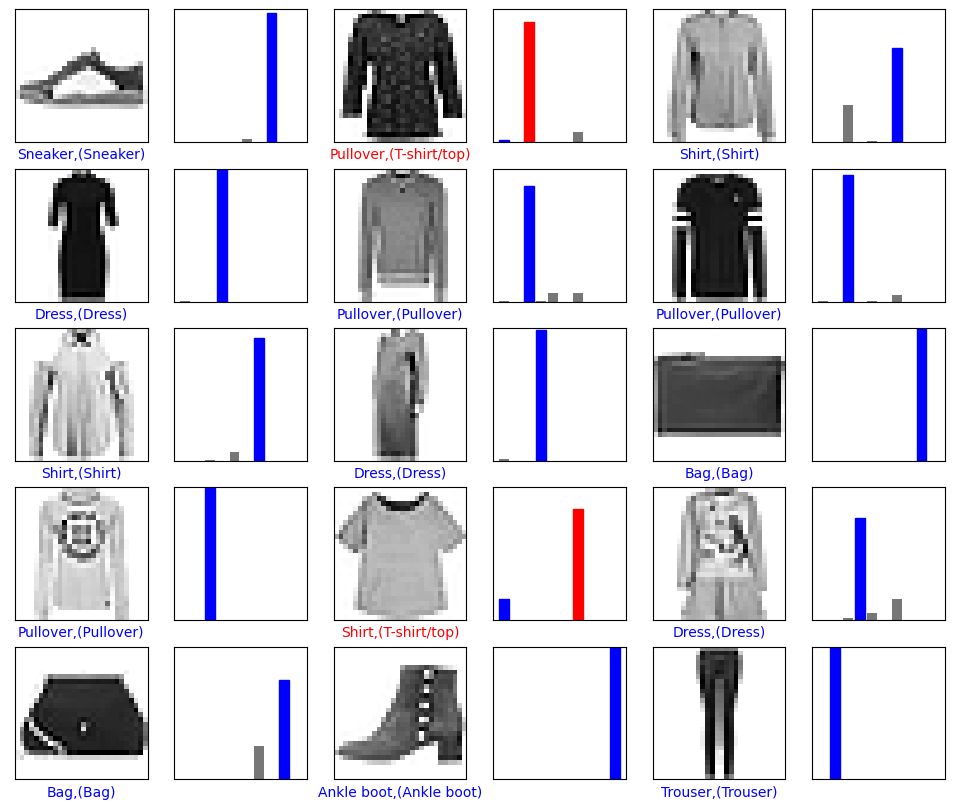

In [13]:
# 预测15个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]
    predicted_label = np.argmax(pred_np_)
    image_single = test_['x'][i, 0, ...].asnumpy()
    plot_image(predicted_label, true_label[i], image_single)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(predicted_label, true_label[i], pred_np_)
plt.show()